In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib.colors import ListedColormap
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import silhouette_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import RFE
from sklearn.linear_model import Ridge
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.stats import f_oneway
from scipy import stats
from scipy.stats import ttest_ind
from collections import defaultdict
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import chi2_contingency
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import spearmanr
import ast
import scikit_posthocs as sp


# We used some of the analysis in this file in our presentation.



df_cluster = pd.read_csv('movie_reviews_with_clusters.csv')
df = pd.read_csv('preprocessed_data.csv')
review = pd.read_csv('final_df.csv')

merged_df = pd.merge(df, df_cluster, on='userid', how='left', suffixes=('_df', '_df_cluster'))
merged_df= merged_df[['userid','openness_df','agreeableness_df', 'emotional_stability_df',
       'conscientiousness_df', 'extraversion_df', 'movie_id', 'rating',
       'title', 'directedBy', 'starring', 'avgRating', 'imdbId','UMAP_1', 'UMAP_2', 'GMM_Cluster']]

In [2]:
merged_df.head()

,userid,openness_df,agreeableness_df,emotional_stability_df,conscientiousness_df,extraversion_df,movie_id,rating,title,directedBy,starring,avgRating,imdbId,UMAP_1,UMAP_2,GMM_Cluster
0,0,5.0,2.0,3.0,2.5,6.5,1,5.0,Toy Story (1995),John Lasseter,"Tim Allen, Tom Hanks, Don Rickles, Jim Varney,...",3.89146,114709,8.999709,4.66991,6
1,0,5.0,2.0,3.0,2.5,6.5,5265,4.0,Death to Smoochy (2002),Danny DeVito,"Danny DeVito, Edward Norton, Robin Williams, C...",3.15655,266452,8.999709,4.66991,6
2,0,5.0,2.0,3.0,2.5,6.5,5258,3.0,George Washington (2000),David Gordon Green,"Curtis Cotton III, Donald Holden, Damian Jewan...",3.58985,262432,8.999709,4.66991,6
3,0,5.0,2.0,3.0,2.5,6.5,5256,4.0,Stolen Summer (2002),Pete Jones,"Brian Dennehy, Kevin Pollak, Aidan Quinn, Bonn...",2.98246,286162,8.999709,4.66991,6
4,0,5.0,2.0,3.0,2.5,6.5,97752,3.5,Cloud Atlas (2012),"Tom Tykwer, Andy Wachowski, Lana Wachowski","Tom Hanks, Halle Berry, Jim Broadbent, Hugo We...",3.56958,1371111,8.999709,4.66991,6


In [3]:
review.head()

,userid,openness,agreeableness,emotional_stability,conscientiousness,extraversion,rating,title,avgRating,GMM_Cluster,review1,review1_results,review2,review2_results,results,positive_tag,negative_tag
0,0,5.0,2.0,3.0,2.5,6.5,5.0,Toy Story (1995),3.89146,6,Toy Story is not only the best Disney film bec...,"{'story': 'positive', 'animation': 'positive',...",I am a big fan of the animated movies coming f...,"{'animation': 'positive', 'visual effects': 'p...","{'storytelling': 'positive', 'climax': 'positi...","['storytelling', 'climax', 'voice acting', 'vi...",[]
1,0,5.0,2.0,3.0,2.5,6.5,4.0,Death to Smoochy (2002),3.15655,6,This film is a dark comedy directed by Danny D...,"{'genre': 'positive', 'plot': 'positive', 'hum...",I've never seen a Danny De Vito film I didn't ...,"{'acting': 'positive', 'comedy': 'positive', '...","{'overall experience': 'positive', 'language':...","['overall experience', 'comedy', 'acting', 'pl...","['language', 'controversy']"
2,0,5.0,2.0,3.0,2.5,6.5,3.5,Cloud Atlas (2012),3.56958,6,There can be little doubt that Cloud Atlas wil...,"{'visual effects': 'positive', 'plot': 'negati...",Kudos to all the filmmakers for adapting this ...,"{'theme': 'positive', 'plot': 'positive', 'tec...","{'overall experience': 'positive', 'narrative ...","['overall experience', 'narrative structure', ...",[]
3,0,5.0,2.0,3.0,2.5,6.5,4.0,From Dusk Till Dawn (1996),3.33222,6,"I enjoyed this film, but I was left a little p...","{'plot': 'negative', 'genre': 'negative'}",The first half of this film is like anything y...,"{'soundtrack': 'positive', 'dialogue': 'positi...","{'genre vampire film': 'positive', 'performanc...","['genre vampire film', 'performance george clo...",['genre']
4,0,5.0,2.0,3.0,2.5,6.5,2.5,Hotel Transylvania (2012),3.45102,6,I gave this a complete 10 because both the wif...,"{'genre': 'positive', 'overall experience': 'p...",I went to see Hotel Transylvania last night in...,"{'plot': 'positive', 'character': 'positive', ...","{'overall experience': 'positive', 'character'...","['overall experience', 'character', 'humor', '...",[]


# Visualizing 7 Clusters by OCEAN

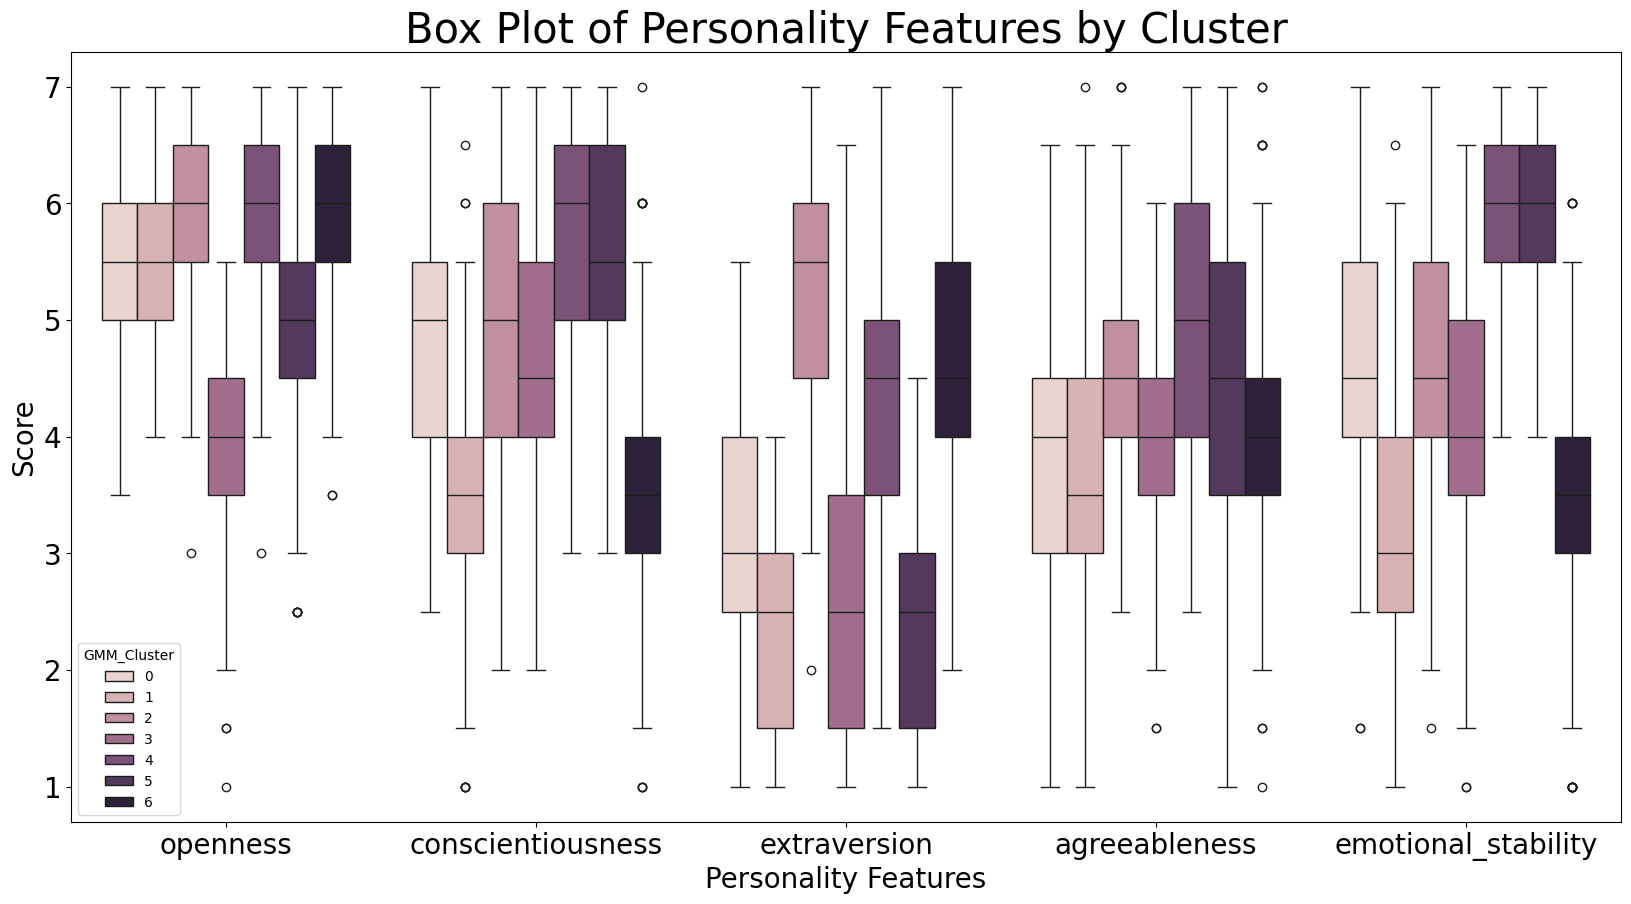

In [4]:
df_melted = df_cluster.melt(id_vars=['GMM_Cluster'], 
                    value_vars=['openness', 'conscientiousness', 'extraversion', 'agreeableness', 'emotional_stability'], 
                    var_name='Personality Features', value_name='Score')

plt.figure(figsize=(20, 10))
sns.boxplot(x='Personality Features', y='Score', hue='GMM_Cluster', data=df_melted)
plt.title('Box Plot of Personality Features by Cluster',fontsize=30)
plt.xlabel('Personality Features',fontsize=20)
plt.ylabel('Score',fontsize=20)
plt.xticks(rotation=0,fontsize=20)
plt.yticks(fontsize=20)
plt.show()

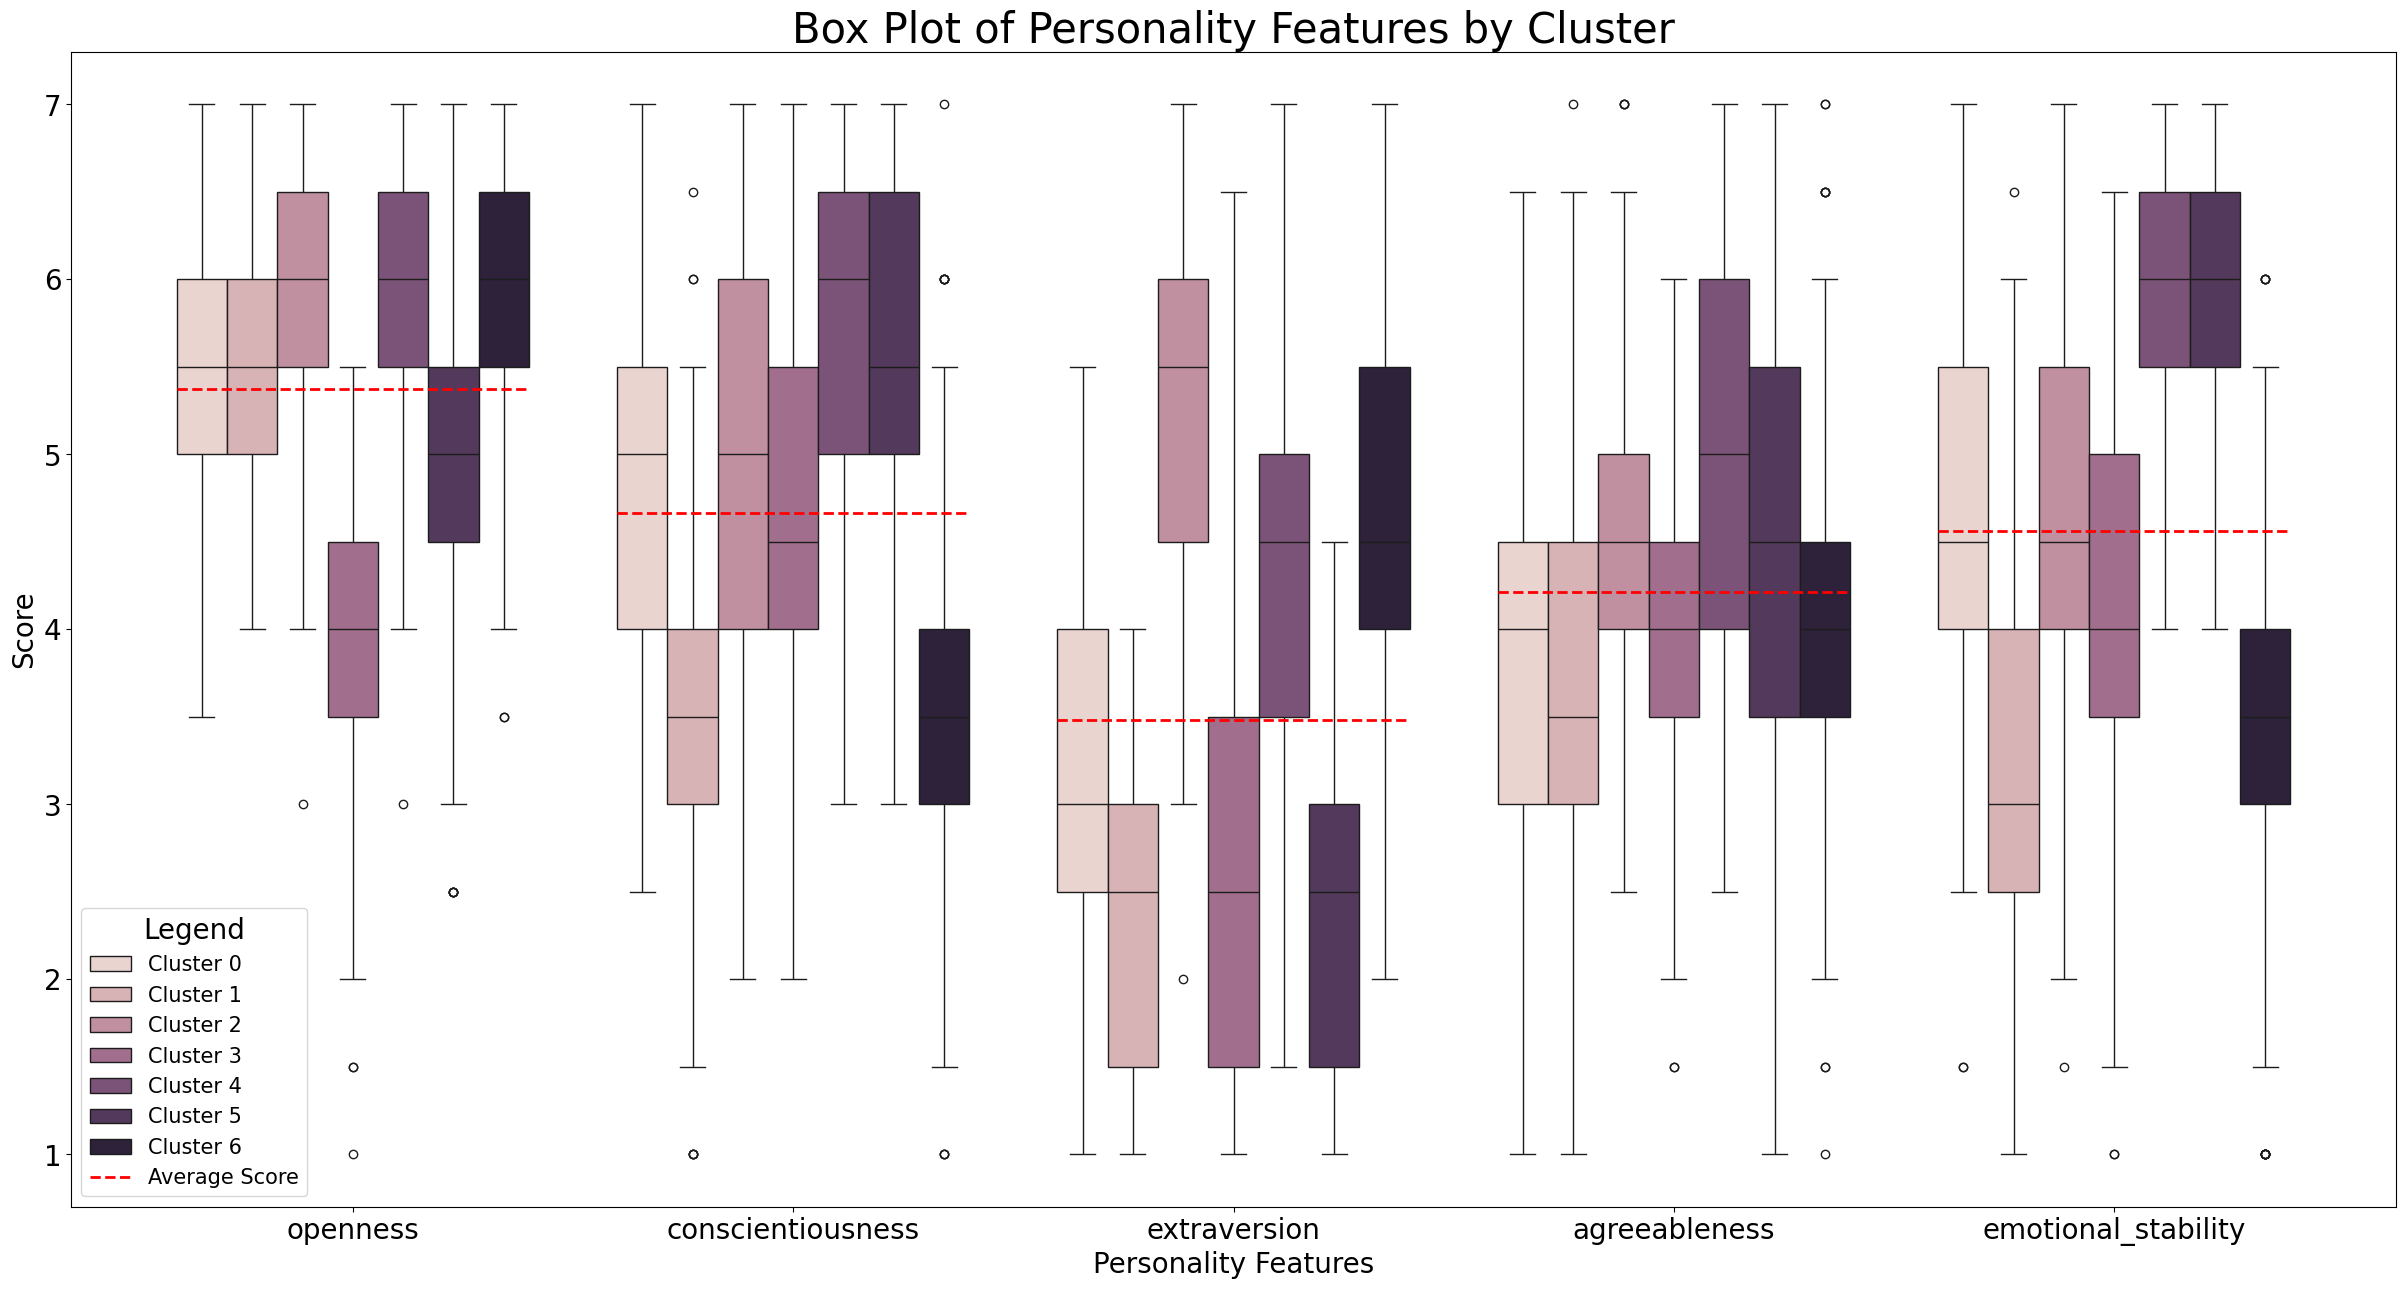

In [5]:
mean_scores = df_cluster[['openness', 'conscientiousness', 'extraversion', 'agreeableness', 'emotional_stability']].mean()

plt.figure(figsize=(30, 15))
ax = sns.boxplot(x='Personality Features', y='Score', hue='GMM_Cluster', data=df_melted)

for i, feature in enumerate(mean_scores.index):
    x_positions = df_melted['Personality Features'].unique()
    xpos = list(x_positions).index(feature)
    plt.hlines(y=mean_scores[feature], xmin=xpos-0.4, xmax=xpos+0.4, color='red', linestyle='--', linewidth=2)
custom_lines = [Line2D([0], [0], color='red', linestyle='--', linewidth=2, label='Average Score')]
handles, labels = ax.get_legend_handles_labels()
labels = ['Cluster 0','Cluster 1','Cluster 2','Cluster 3','Cluster 4','Cluster 5','Cluster 6']
handles.extend(custom_lines)
labels.extend(['Average Score'])

plt.legend(handles, labels, title='Legend', fontsize=15, title_fontsize=20)
plt.title('Box Plot of Personality Features by Cluster', fontsize=30)
plt.xlabel('Personality Features', fontsize=20)
plt.ylabel('Score', fontsize=20)
plt.xticks(rotation=0, fontsize=20)
plt.yticks(fontsize=20)
plt.show()

Cluster 6 Shapiro-Wilk test: p-value = 3.952948584757072e-05
Cluster 4 Shapiro-Wilk test: p-value = 7.179887072749741e-10
Cluster 3 Shapiro-Wilk test: p-value = 2.9706119024729556e-05
Cluster 0 Shapiro-Wilk test: p-value = 3.2627267447292995e-05
Cluster 1 Shapiro-Wilk test: p-value = 4.66670229310874e-05
Cluster 5 Shapiro-Wilk test: p-value = 6.949301323370019e-09
Cluster 2 Shapiro-Wilk test: p-value = 0.0003700162591100906
Levene’s test for homogeneity of variances: p-value = 1.545627672180121e-13
                     sum_sq      df           F         PR(>F)
C(GMM_Cluster)  1842.583211     6.0  326.127065  7.169114e-284
Residual        1707.209509  1813.0         NaN            NaN


C:\Users\jwlee\AppData\Local\Temp\ipykernel_728\2498610770.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if anova_table['PR(>F)'][0] < 0.05:


Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     0      1   -1.628    0.0 -1.8774 -1.3786   True
     0      2  -0.2293 0.0874 -0.4755   0.017  False
     0      3  -0.6616    0.0 -0.8933   -0.43   True
     0      4   1.1927    0.0  0.9512  1.4342   True
     0      5    1.166    0.0  0.9206  1.4114   True
     0      6  -1.4058    0.0 -1.6484 -1.1632   True
     1      2   1.3987    0.0  1.1327  1.6647   True
     1      3   0.9664    0.0  0.7139  1.2189   True
     1      4   2.8207    0.0  2.5591  3.0823   True
     1      5    2.794    0.0  2.5288  3.0592   True
     1      6   0.2222 0.1605 -0.0404  0.4848  False
     2      3  -0.4324    0.0 -0.6818 -0.1829   True
     2      4   1.4219    0.0  1.1633  1.6806   True
     2      5   1.3952    0.0  1.1329  1.6575   True
     2      6  -1.1765    0.0 -1.4362 -0.9168   True
     3      4   1.8543    0.0  1.6095  2.0991 

C:\Users\jwlee\AppData\Local\Temp\ipykernel_728\2498610770.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='GMM_Cluster', y='Score', data=emotional_stability_data,palette=palette)
C:\Users\jwlee\AppData\Local\Temp\ipykernel_728\2498610770.py:31: UserWarning: The palette list has more values (8) than needed (7), which may not be intended.
  sns.boxplot(x='GMM_Cluster', y='Score', data=emotional_stability_data,palette=palette)


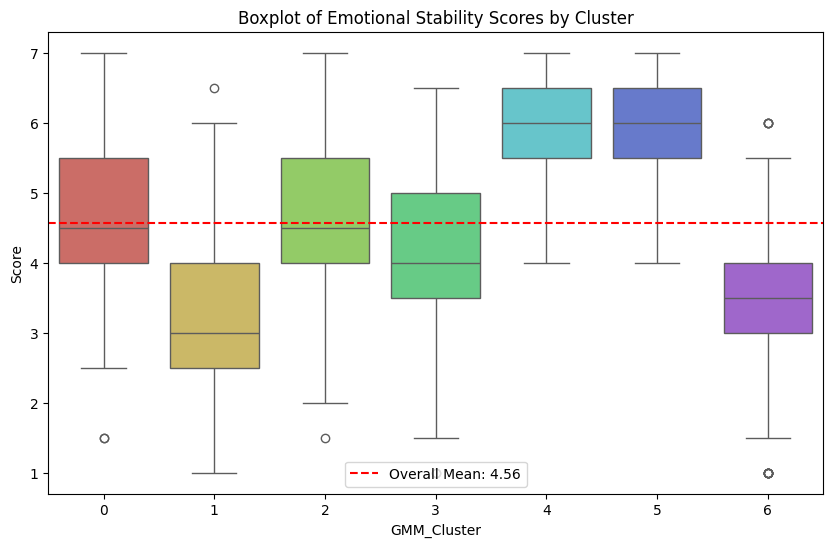

In [6]:
emotional_stability_data = df_melted[df_melted['Personality Features'] == 'emotional_stability']

# 1. Normality
clusters = emotional_stability_data['GMM_Cluster'].unique()
for cluster in clusters:
    cluster_data = emotional_stability_data[emotional_stability_data['GMM_Cluster'] == cluster]['Score']
    print(f'Cluster {cluster} Shapiro-Wilk test: p-value = {stats.shapiro(cluster_data)[1]}')

# 2. Homogeneity of variances
levene_test = stats.levene(*[emotional_stability_data[emotional_stability_data['GMM_Cluster'] == cluster]['Score'] for cluster in clusters])
print(f'Levene’s test for homogeneity of variances: p-value = {levene_test.pvalue}')

# Perform ANOVA
model = ols('Score ~ C(GMM_Cluster)', data=emotional_stability_data).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

# If ANOVA is significant, perform post hoc test (Tukey's HSD)
if anova_table['PR(>F)'][0] < 0.05:
    from statsmodels.stats.multicomp import pairwise_tukeyhsd
    tukey = pairwise_tukeyhsd(endog=emotional_stability_data['Score'],
                              groups=emotional_stability_data['GMM_Cluster'],
                              alpha=0.05)
    print(tukey)

overall_mean = emotional_stability_data['Score'].mean()

palette = sns.color_palette("hls", 8)

plt.figure(figsize=(10, 6))
sns.boxplot(x='GMM_Cluster', y='Score', data=emotional_stability_data,palette=palette)
plt.axhline(y=overall_mean, color='red', linestyle='--', label=f'Overall Mean: {overall_mean:.2f}')
plt.legend()
plt.title('Boxplot of Emotional Stability Scores by Cluster')
plt.show()

In [7]:
# Since Normality Assumption is not met,
# Perform Kruskal-Wallis H-test and Dunn's test(for a post-hoc test)
data_by_cluster = [emotional_stability_data.loc[emotional_stability_data['GMM_Cluster'] == cluster, 'Score'].values for cluster in clusters]
stat, p_value = stats.kruskal(*data_by_cluster)

print(f'Kruskal-Wallis H-statistic: {stat:.4f}')
print(f'p-value: {p_value:.4f}')

if p_value < 0.05:
    posthoc = sp.posthoc_dunn(emotional_stability_data, val_col='Score', group_col='GMM_Cluster', p_adjust='bonferroni')
    print(posthoc)

Kruskal-Wallis H-statistic: 975.7731
p-value: 0.0000
              0              1             2             3              4  \
0  1.000000e+00   3.993546e-38  1.000000e+00  3.841149e-08   4.071976e-25   
1  3.993546e-38   1.000000e+00  1.628194e-24  1.787907e-12  2.497233e-109   
2  1.000000e+00   1.628194e-24  1.000000e+00  5.435254e-03   8.572014e-31   
3  3.841149e-08   1.787907e-12  5.435254e-03  1.000000e+00   1.268392e-57   
4  4.071976e-25  2.497233e-109  8.572014e-31  1.268392e-57   1.000000e+00   
5  1.464448e-23  6.696728e-105  3.775205e-29  1.033286e-54   1.000000e+00   
6  3.055381e-30   1.000000e+00  2.573489e-18  9.172202e-08   2.765445e-98   

               5             6  
0   1.464448e-23  3.055381e-30  
1  6.696728e-105  1.000000e+00  
2   3.775205e-29  2.573489e-18  
3   1.033286e-54  9.172202e-08  
4   1.000000e+00  2.765445e-98  
5   1.000000e+00  4.568892e-94  
6   4.568892e-94  1.000000e+00  


Same result that Cluster 1 and 6 are not significantly different

Cluster 6 Shapiro-Wilk test: p-value = 0.00033930965734466474
Cluster 4 Shapiro-Wilk test: p-value = 1.5012434580754742e-08
Cluster 3 Shapiro-Wilk test: p-value = 1.408097806183996e-05
Cluster 0 Shapiro-Wilk test: p-value = 7.858432591038025e-06
Cluster 1 Shapiro-Wilk test: p-value = 0.00024471107151952565
Cluster 5 Shapiro-Wilk test: p-value = 3.4720011220604413e-08
Cluster 2 Shapiro-Wilk test: p-value = 6.219863475802028e-05
Levene’s test for homogeneity of variances: p-value = 7.475439796914642e-05
                     sum_sq      df           F         PR(>F)
C(GMM_Cluster)  1296.889455     6.0  211.779114  5.538638e-205
Residual        1850.403265  1813.0         NaN            NaN


C:\Users\jwlee\AppData\Local\Temp\ipykernel_728\2850925491.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if anova_table['PR(>F)'][0] < 0.05:


Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     0      1   -1.438    0.0 -1.6976 -1.1784   True
     0      2  -0.0001    1.0 -0.2565  0.2563  False
     0      3  -0.3975    0.0 -0.6386 -0.1563   True
     0      4   0.8401    0.0  0.5886  1.0916   True
     0      5   0.9142    0.0  0.6587  1.1697   True
     0      6  -1.3707    0.0 -1.6233 -1.1182   True
     1      2   1.4379    0.0   1.161  1.7149   True
     1      3   1.0406    0.0  0.7777  1.3035   True
     1      4   2.2781    0.0  2.0058  2.5505   True
     1      5   2.3522    0.0  2.0761  2.6283   True
     1      6   0.0673  0.991 -0.2061  0.3407  False
     2      3  -0.3974 0.0001 -0.6571 -0.1376   True
     2      4   0.8402    0.0  0.5709  1.1095   True
     2      5   0.9143    0.0  0.6412  1.1873   True
     2      6  -1.3706    0.0  -1.641 -1.1003   True
     3      4   1.2375    0.0  0.9827  1.4924 

C:\Users\jwlee\AppData\Local\Temp\ipykernel_728\2850925491.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='GMM_Cluster', y='Score', data=conscientiousness_data,palette=palette)
C:\Users\jwlee\AppData\Local\Temp\ipykernel_728\2850925491.py:30: UserWarning: The palette list has more values (8) than needed (7), which may not be intended.
  sns.boxplot(x='GMM_Cluster', y='Score', data=conscientiousness_data,palette=palette)


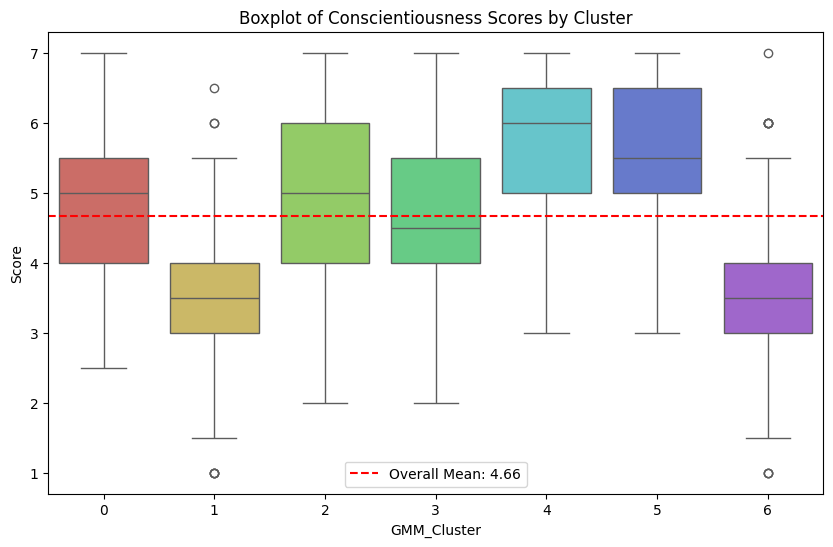

In [8]:
conscientiousness_data = df_melted[df_melted['Personality Features'] == 'conscientiousness']

# Check assumptions
# 1. Normality
clusters = conscientiousness_data['GMM_Cluster'].unique()
for cluster in clusters:
    cluster_data = conscientiousness_data[conscientiousness_data['GMM_Cluster'] == cluster]['Score']
    print(f'Cluster {cluster} Shapiro-Wilk test: p-value = {stats.shapiro(cluster_data)[1]}')

# 2. Homogeneity of variances
levene_test = stats.levene(*[conscientiousness_data[conscientiousness_data['GMM_Cluster'] == cluster]['Score'] for cluster in clusters])
print(f'Levene’s test for homogeneity of variances: p-value = {levene_test.pvalue}')

# Perform ANOVA
model = ols('Score ~ C(GMM_Cluster)', data=conscientiousness_data).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

# If ANOVA is significant, perform post hoc test (Tukey's HSD)
if anova_table['PR(>F)'][0] < 0.05:
    from statsmodels.stats.multicomp import pairwise_tukeyhsd
    tukey = pairwise_tukeyhsd(endog=conscientiousness_data['Score'],
                              groups=conscientiousness_data['GMM_Cluster'],
                              alpha=0.05)
    print(tukey)

overall_mean = conscientiousness_data['Score'].mean()

plt.figure(figsize=(10, 6))
sns.boxplot(x='GMM_Cluster', y='Score', data=conscientiousness_data,palette=palette)
plt.axhline(y=overall_mean, color='red', linestyle='--', label=f'Overall Mean: {overall_mean:.2f}')
plt.legend()
plt.title('Boxplot of Conscientiousness Scores by Cluster')
plt.show()

In [9]:
# Since Normality Assumption is not met,
# Perform Kruskal-Wallis H-test and Dunn's test(for a post-hoc test)
data_by_cluster = [conscientiousness_data[conscientiousness_data['GMM_Cluster'] == cluster]['Score'].values for cluster in clusters]
stat, p_value = stats.kruskal(*data_by_cluster)

print(f'Kruskal-Wallis H-statistic: {stat:.4f}')
print(f'p-value: {p_value:.4f}')

if p_value < 0.05:
    posthoc = sp.posthoc_dunn(conscientiousness_data, val_col='Score', group_col='GMM_Cluster', p_adjust='bonferroni')
    print(posthoc)

Kruskal-Wallis H-statistic: 756.6664
p-value: 0.0000
              0             1             2             3             4  \
0  1.000000e+00  2.829038e-33  1.000000e+00  1.635275e-03  3.996724e-14   
1  2.829038e-33  1.000000e+00  1.351037e-29  4.320728e-16  1.953989e-79   
2  1.000000e+00  1.351037e-29  1.000000e+00  3.961707e-03  3.910614e-12   
3  1.635275e-03  4.320728e-16  3.961707e-03  1.000000e+00  1.078992e-29   
4  3.996724e-14  1.953989e-79  3.910614e-12  1.078992e-29  1.000000e+00   
5  3.199866e-16  9.808032e-83  5.202569e-14  2.291603e-32  1.000000e+00   
6  7.946033e-32  1.000000e+00  3.920519e-28  1.027235e-14  1.433468e-78   

              5             6  
0  3.199866e-16  7.946033e-32  
1  9.808032e-83  1.000000e+00  
2  5.202569e-14  3.920519e-28  
3  2.291603e-32  1.027235e-14  
4  1.000000e+00  1.433468e-78  
5  1.000000e+00  6.857711e-82  
6  6.857711e-82  1.000000e+00  


Same result that Cluster 1 and 6 are not significantly different

# ABSA Tag Analysis

In [10]:
review['positive_tag'] = review['positive_tag'].apply(ast.literal_eval)
review['negative_tag'] = review['negative_tag'].apply(ast.literal_eval)

In [11]:
total = review.copy()
tag = total.drop_duplicates(subset=['title'])

In [12]:
count_dict = defaultdict(lambda: {'positive': 0, 'negative': 0})

for index, row in tag.iterrows():
    for tag in row['positive_tag']:
        count_dict[tag]['positive'] += 1
    for tag in row['negative_tag']:
        count_dict[tag]['negative'] += 1

total_count = pd.DataFrame.from_dict(count_dict, orient='index')
total_count  # All Tags of Movies of Top 2528

,positive,negative
storytelling,29,6
climax,5,1
voice acting,18,1
visual effects,316,104
entertainment value,38,16
...,...,...
street life,1,0
film industry,1,0
self-discovery,1,0
indie films,0,1


In [13]:
total['rating_difference'] = total['rating'] - total['avgRating']
mean_ratings = total.groupby(['title', 'GMM_Cluster'])['rating_difference'].mean().reset_index()
pivot_df = mean_ratings.pivot(index='title', columns='GMM_Cluster', values='rating_difference').reset_index()

# Movies that FoMO Clusters rated relatively higher than other clusters
filtered_titles_top16 = pivot_df[
    (pivot_df[1] > pivot_df.drop(columns=['title',1, 6]).max(axis=1)) & 
    (pivot_df[6] > pivot_df.drop(columns=['title',1, 6]).max(axis=1))
] 
# Movies that FoMO Clusters rated relatively lower than other clusters
filtered_titles_bottom16 = pivot_df[
    (pivot_df[1] < pivot_df.drop(columns=['title',1, 6]).min(axis=1)) & 
    (pivot_df[6] < pivot_df.drop(columns=['title',1, 6]).min(axis=1))
]

In [14]:
top16 = pd.merge(total, filtered_titles_top16, on='title', how='inner')
tag_top16 = top16.drop_duplicates(subset=['title'])

count_dict = defaultdict(lambda: {'positive': 0, 'negative': 0})

for index, row in tag_top16.iterrows():
    for tag in row['positive_tag']:
        count_dict[tag]['positive'] += 1
    for tag in row['negative_tag']:
        count_dict[tag]['negative'] += 1

top16_count = pd.DataFrame.from_dict(count_dict, orient='index')
top16_count # All Tags of Movies that FoMO Clusters rated relatively higher than other clusters

,positive,negative
setting,5,0
visuals,13,2
cinematography,19,0
character,37,7
character development,6,0
...,...,...
directing,1,0
franchise,0,1
audience engagement,1,0
stunts,0,1


In [15]:
bottom16 = pd.merge(total, filtered_titles_bottom16, on='title', how='inner')
tag_bottom16 = bottom16.drop_duplicates(subset=['title'])

count_dict = defaultdict(lambda: {'positive': 0, 'negative': 0})

for index, row in tag_bottom16.iterrows():
    for tag in row['positive_tag']:
        count_dict[tag]['positive'] += 1
    for tag in row['negative_tag']:
        count_dict[tag]['negative'] += 1

bottom16_count = pd.DataFrame.from_dict(count_dict, orient='index')
bottom16_count # All Tags of Movies that FoMO Clusters rated relatively lower than other clusters

,positive,negative
acting,20,4
character,65,29
war,2,3
theme,80,28
duty,0,1
...,...,...
box office success,1,0
investment,1,0
lead roles,1,0
satire,1,0


In [16]:
total_count['total'] = total_count['positive'] + total_count['negative']
top16_count['total'] = top16_count['positive'] + top16_count['negative']
bottom16_count['total'] = bottom16_count['positive'] + bottom16_count['negative']

total_count = total_count.sort_values(by='total', ascending=False)
top16_count = top16_count.sort_values(by='total', ascending=False)
bottom16_count = bottom16_count.sort_values(by='total', ascending=False)

total_counts = total_count['total']
top16_counts = top16_count['total']
bottom16_counts = bottom16_count['total']

In [17]:
total_counts.head()

theme                 1154
character             1034
plot                   700
visual effects         420
overall experience     329
Name: total, dtype: int64

In [18]:
top16_counts.head()

theme             55
character         44
plot              41
cinematography    19
visual effects    19
Name: total, dtype: int64

In [19]:
bottom16_counts.head()

theme             108
character          94
plot               74
visual effects     46
humor              44
Name: total, dtype: int64

- ## **Z-Test for Tags**

In [20]:
results = []

# Z Test for each tags
for tag in top16_counts.index:
    if tag in total_counts.index:
        top_positive = top16_counts[tag]
        total_positive = total_counts[tag]

        count = [top_positive, total_positive]
        nobs = [len(filtered_titles_top16), len(review['title'].value_counts())]

        # Z Test
        stat, pval = proportions_ztest(count, nobs)

        results.append({'태그': tag, 'Z-통계량': stat, 'p-값': pval, 'total': top_positive})

test_top16 = pd.DataFrame(results)
test_top16

,태그,Z-통계량,p-값,total
0,theme,-0.202939,0.839183,55
1,character,-1.130969,0.258068,44
2,plot,1.361964,0.173209,41
3,cinematography,1.434051,0.151558,19
4,visual effects,-0.339943,0.733899,19
...,...,...,...,...
164,climax,1.214890,0.224408,1
165,coherence,2.364067,0.018076,1
166,ideas,3.050864,0.002282,1
167,depth,1.402136,0.160875,1


In [21]:
# Tags with significantly high frequencies in Movies that FoMO Clusters rated relatively higher than other clusters
test_top16[test_top16['p-값']<0.05].head()

,태그,Z-통계량,p-값,total
6,horror,2.930412,0.003385,16
8,visuals,3.329503,0.000870,15
25,fantasy,1.987892,0.046824,4
27,remake,3.032315,0.002427,4
34,narrative,2.994349,0.002750,3


In [22]:
results = []

# Z Test for each tags
for tag in bottom16_counts.index:
    if tag in total_counts.index:
        bottom_positive = bottom16_counts[tag]
        total_positive = total_counts[tag]

        count = [bottom_positive, total_positive]
        nobs = [len(filtered_titles_bottom16), len(review['title'].value_counts())]

        # Z Test
        stat, pval = proportions_ztest(count, nobs)

        results.append({'태그': tag, 'Z-통계량': stat, 'p-값': pval,'total': bottom_positive})

test_bottom16 = pd.DataFrame(results)
test_bottom16

,태그,Z-통계량,p-값,total
0,theme,-0.023381,0.981347,108
1,character,-0.371245,0.710455,94
2,plot,1.158619,0.246612,74
3,visual effects,1.099222,0.271671,46
4,humor,2.531504,0.011357,44
...,...,...,...,...
268,antagonists,2.093652,0.036291,1
269,philosophy,0.709103,0.478260,1
270,timing,1.174564,0.240169,1
271,audience respect,1.532897,0.125301,1


In [23]:
# Tags with significantly high frequencies in Movies that FoMO Clusters rated relatively lower than other clusters
test_bottom16[test_bottom16['p-값']<0.05].head()

,태그,Z-통계량,p-값,total
4,humor,2.531504,0.011357,44
16,franchise,2.540121,0.011081,12
30,screenplay,2.518533,0.011784,7
38,characterization,2.155207,0.031146,5
61,inspiration,2.220067,0.026414,3


# EDA (which were not included in presentation)

- ## Radar Chart for Visualizing 7 Clusters by OCEAN

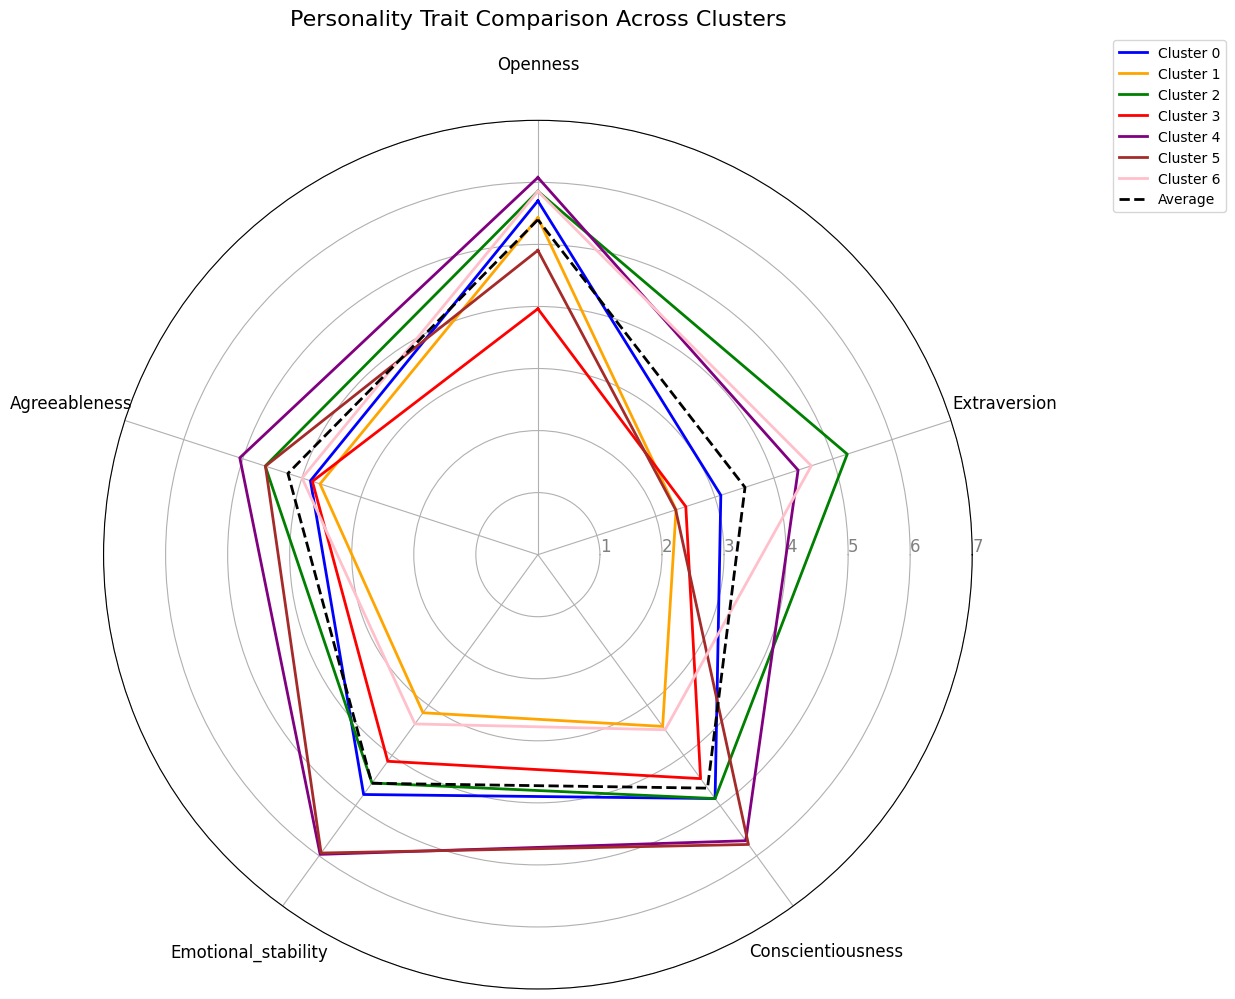

In [24]:
def radar_chart(df, title):
    # Number of variables
    categories = list(df.columns)
    N = len(categories)

    # Compute the angle for each axis
    angles = [n / float(N) * 2 * np.pi for n in range(N)]

    # Rotate to put 'emotional_stability' at the top
    rotation = np.pi / 2  # 90 degrees in radians
    angles = [(angle + rotation) % (2 * np.pi) for angle in angles]

    angles += angles[:1]  # Complete the loop

    # Initialise the plot
    fig, ax = plt.subplots(figsize=(12, 10), subplot_kw=dict(projection='polar'))

    # Draw one axis per variable + add labels
    plt.xticks(angles[:-1], categories, size=12)
    ax.xaxis.set_tick_params(pad=30)

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([1, 2, 3, 4, 5, 6, 7], ["1", "2", "3", "4", "5", "6", "7"], color="grey", size=12)
    plt.ylim(0, 7)

    # Plot data
    colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'cyan']
    for i, row in df.iterrows():
        values = row.values.flatten().tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=f"Cluster {i}", color=colors[i])
        #ax.fill(angles, values, alpha=0.1, color=colors[i])

    # Add average line
    avg_values = df.mean(axis=0).tolist()
    avg_values += avg_values[:1]
    ax.plot(angles, avg_values, linewidth=2, linestyle='dashed', label='Average', color='black')
    #ax.fill(angles, avg_values, alpha=0.1, color='black')

    # Add legend
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

    # Add a title
    plt.title(title, size=16, y=1.1)

    return fig

cluster_means = df_cluster.groupby('GMM_Cluster')[['openness', 'agreeableness', 'emotional_stability', 'conscientiousness', 'extraversion']].mean()
cluster_means.columns = [col.capitalize() for col in cluster_means.columns]
fig = radar_chart(cluster_means, 'Personality Trait Comparison Across Clusters')

plt.tight_layout()
plt.show()

- ## Average rating by cluster & Average number of reviews by cluster

   GMM_Cluster  Average_Rating
0            0        3.274861
1            1        3.281062
2            2        3.394065
3            3        3.376814
4            4        3.442661
5            5        3.384599
6            6        3.426134


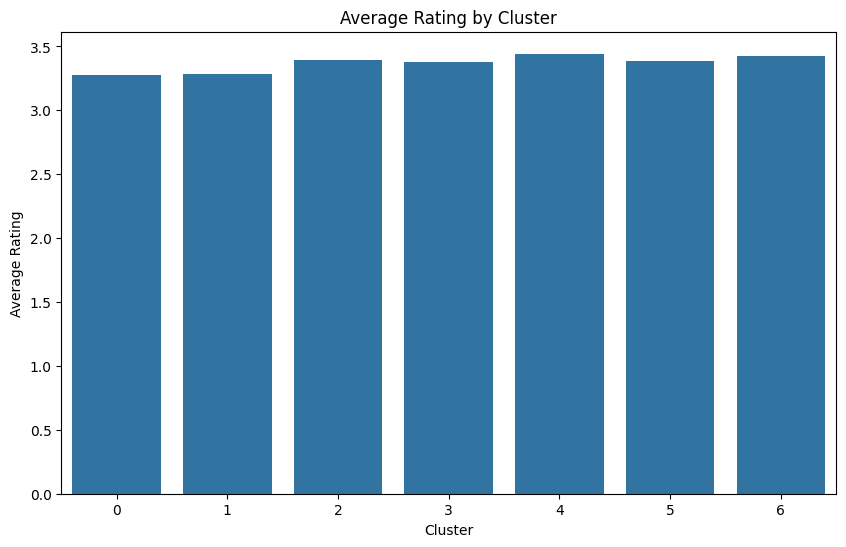

In [25]:
# Average rating by cluster
avg_rating_by_cluster = merged_df.groupby('GMM_Cluster')['rating'].mean().reset_index()
avg_rating_by_cluster.columns = ['GMM_Cluster', 'Average_Rating']
print(avg_rating_by_cluster)

plt.figure(figsize=(10, 6))
sns.barplot(x='GMM_Cluster', y='Average_Rating', data=avg_rating_by_cluster)
plt.title('Average Rating by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Rating')
plt.show()


   GMM_Cluster  Number_of_Reviews
0            0             190329
1            1             149636
2            2             145151
3            3             166520
4            4             144726
5            5             143266
6            6             127440


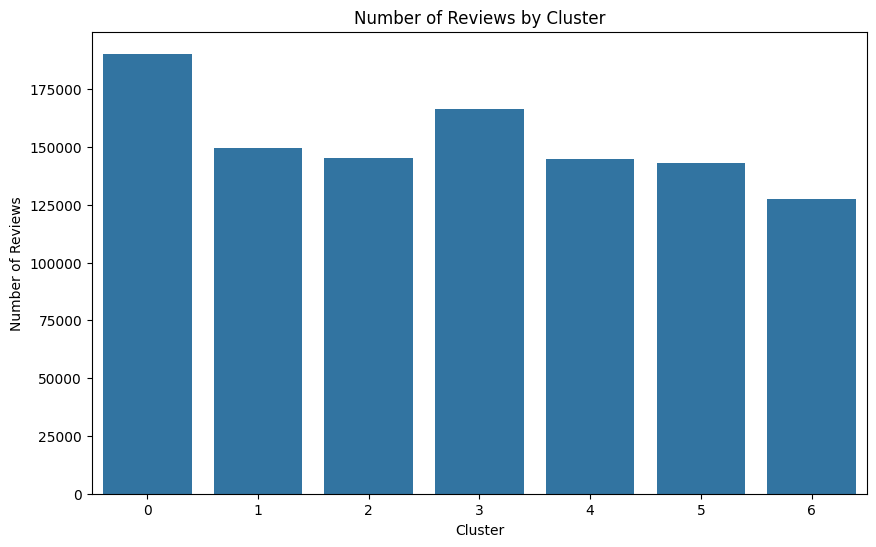

In [26]:
# Number of reviews by cluster
reviews_by_cluster = merged_df.groupby('GMM_Cluster')['rating'].count().reset_index()
reviews_by_cluster.columns = ['GMM_Cluster', 'Number_of_Reviews']
print(reviews_by_cluster)

plt.figure(figsize=(10, 6))
sns.barplot(x='GMM_Cluster', y='Number_of_Reviews', data=reviews_by_cluster)
plt.title('Number of Reviews by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Reviews')
plt.show()


In [27]:
# Number of unique users by cluster
users_by_cluster = merged_df.groupby('GMM_Cluster')['userid'].nunique().reset_index()
users_by_cluster.columns = ['GMM_Cluster', 'Number_of_Users']

num_reviews_summary = reviews_by_cluster.merge(users_by_cluster, on='GMM_Cluster')

# Average number of reviews by cluster
num_reviews_summary['Average_Reviews_Per_User'] = num_reviews_summary['Number_of_Reviews'] / num_reviews_summary['Number_of_Users']

# Overall average number of reviews by cluster
overall_average_reviews_per_user = num_reviews_summary['Average_Reviews_Per_User'].mean()
print(f"Overall Average Number of Reviews per User: {overall_average_reviews_per_user:.2f}")

# Relative Difference to the overall average number of reviews
num_reviews_summary['Comparison_to_Overall_Average'] = num_reviews_summary['Average_Reviews_Per_User'] - overall_average_reviews_per_user

num_reviews_summary

Overall Average Number of Reviews per User: 587.57


,GMM_Cluster,Number_of_Reviews,Number_of_Users,Average_Reviews_Per_User,Comparison_to_Overall_Average
0,0,190329,315,604.219048,16.644416
1,1,149636,227,659.189427,71.614796
2,2,145151,237,612.451477,24.876845
3,3,166520,297,560.673401,-26.901231
4,4,144726,254,569.787402,-17.787230
5,5,143266,240,596.941667,9.367035
6,6,127440,250,509.760000,-77.814632


C:\Users\jwlee\AppData\Local\Temp\ipykernel_728\2811288167.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x='GMM_Cluster', y='Average_Reviews_Per_User', data=num_reviews_summary, palette=palette)
C:\Users\jwlee\AppData\Local\Temp\ipykernel_728\2811288167.py:2: UserWarning: The palette list has more values (8) than needed (7), which may not be intended.
  bar_plot = sns.barplot(x='GMM_Cluster', y='Average_Reviews_Per_User', data=num_reviews_summary, palette=palette)


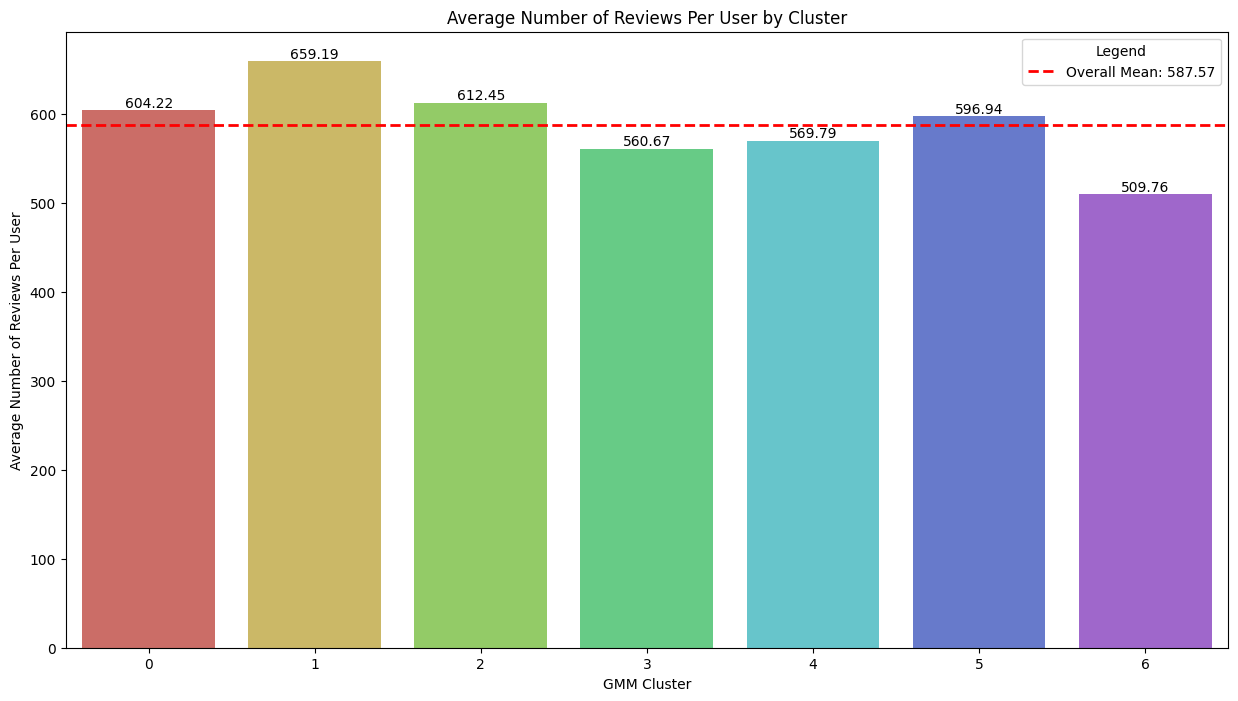

In [28]:
plt.figure(figsize=(15, 8))
bar_plot = sns.barplot(x='GMM_Cluster', y='Average_Reviews_Per_User', data=num_reviews_summary, palette=palette)
plt.title('Average Number of Reviews Per User by Cluster')
plt.xlabel('GMM Cluster')
plt.ylabel('Average Number of Reviews Per User')

for p in bar_plot.patches:
    height = p.get_height()
    bar_plot.annotate(f'{height:.2f}', 
                      (p.get_x() + p.get_width() / 2., height),
                      ha='center', va='center', 
                      xytext=(0, 5),
                      textcoords='offset points')

plt.axhline(y=overall_average_reviews_per_user, color='red', linestyle='--', linewidth=2)

handles, labels = plt.gca().get_legend_handles_labels()
handles.append(plt.Line2D([], [], color='red', linestyle='--', linewidth=2))
labels.append(f'Overall Mean: {overall_average_reviews_per_user:.2f}')
plt.legend(handles=handles, title='Legend', labels=[f'Overall Mean: {overall_average_reviews_per_user:.2f}'])
plt.show()


- ## Correlation Matrix of OCEAN

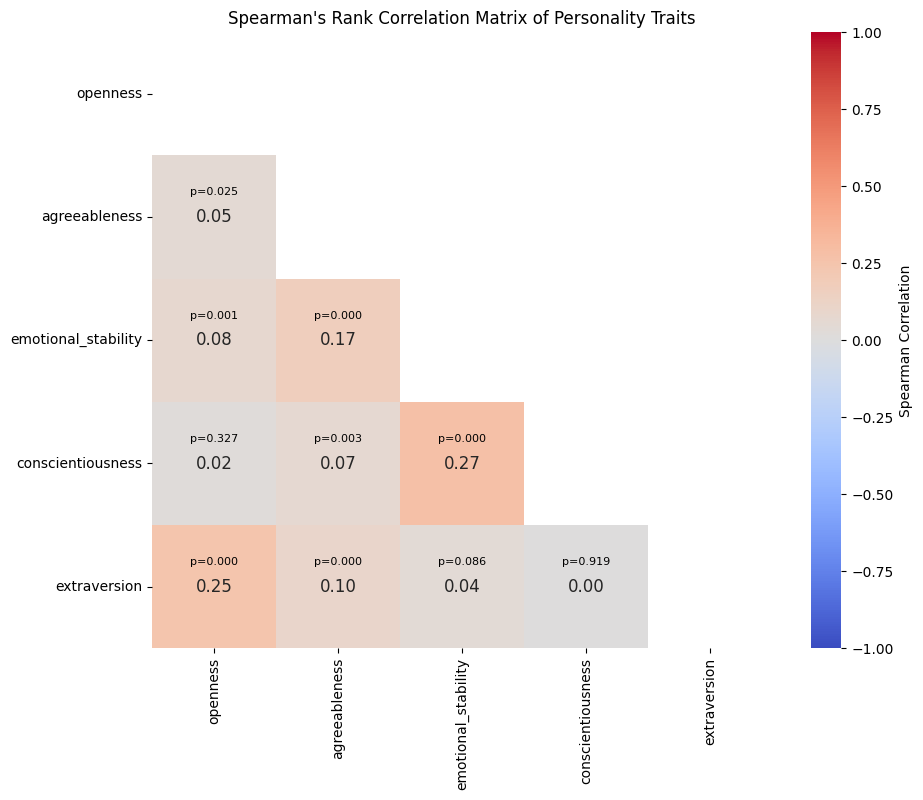

In [29]:
df_ocean = df_cluster[['openness','agreeableness','emotional_stability','conscientiousness','extraversion']]
corr_matrix = df_ocean.corr(method='spearman')
p_values = np.zeros_like(corr_matrix)

for i in range(len(corr_matrix.columns)):
    for j in range(len(corr_matrix.columns)):
        if i != j:
            corr, p_val = spearmanr(df_ocean.iloc[:, i], df_ocean.iloc[:, j])
            p_values[i, j] = p_val

# Mask for the upper triangle (Symmetric)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, cbar_kws={'label': 'Spearman Correlation'}, annot_kws={"size": 12})
plt.title("Spearman's Rank Correlation Matrix of Personality Traits")

for i in range(len(corr_matrix.columns)):
    for j in range(len(corr_matrix.columns)):
        if i != j and not mask[i, j]:
            plt.text(j + 0.5, i + 0.3, f"p={p_values[i, j]:.3f}", 
                     ha='center', va='center', color='black', fontsize=8, rotation=0)

plt.show()

- ## Average of relative rating(rating-avgRating) by cluster

In [30]:
df_mean = merged_df.copy()

# Compute the rating difference(relative rating)
df_mean['rating_difference'] = df_mean['rating'] - df_mean['avgRating']

mean_difference_per_user = df_mean.groupby('userid')['rating_difference'].mean().reset_index()
mean_difference_per_user = mean_difference_per_user.rename(columns={'rating_difference': 'mean_rating_difference'})

df_mean = df_mean.drop_duplicates(subset='userid')
df_mean = df_mean.merge(mean_difference_per_user, on='userid', how='left')
df_mean = df_mean.drop(columns=['rating_difference'])

avg_diff_rating_by_cluster = df_mean.groupby('GMM_Cluster')['mean_rating_difference'].mean().reset_index()
avg_diff_rating_by_cluster.columns = ['GMM_Cluster', 'Average_Rating']
avg_diff_rating_by_cluster

,GMM_Cluster,Average_Rating
0,0,-0.064031
1,1,-0.064139
2,2,0.114236
3,3,-0.059989
4,4,0.035831
5,5,0.022794
6,6,-0.006221


In [31]:
df_mean.groupby('GMM_Cluster').describe()['mean_rating_difference']

,count,mean,std,min,25%,50%,75%,max
GMM_Cluster,,,,,,,,
0,315.0,-0.064031,0.437298,-2.460319,-0.308187,-0.031734,0.227305,1.040327
1,227.0,-0.064139,0.421437,-1.450271,-0.305150,-0.063756,0.202262,1.554455
2,237.0,0.114236,0.399249,-1.074551,-0.109293,0.105010,0.352305,1.305385
3,297.0,-0.059989,0.417337,-2.011179,-0.316292,-0.039250,0.202936,0.897517
4,254.0,0.035831,0.420909,-1.434802,-0.194733,0.064439,0.282015,1.091256
5,240.0,0.022794,0.353283,-0.917904,-0.176614,0.007731,0.255903,1.097048
6,250.0,-0.006221,0.438689,-1.872609,-0.248574,-0.016632,0.289462,1.034867


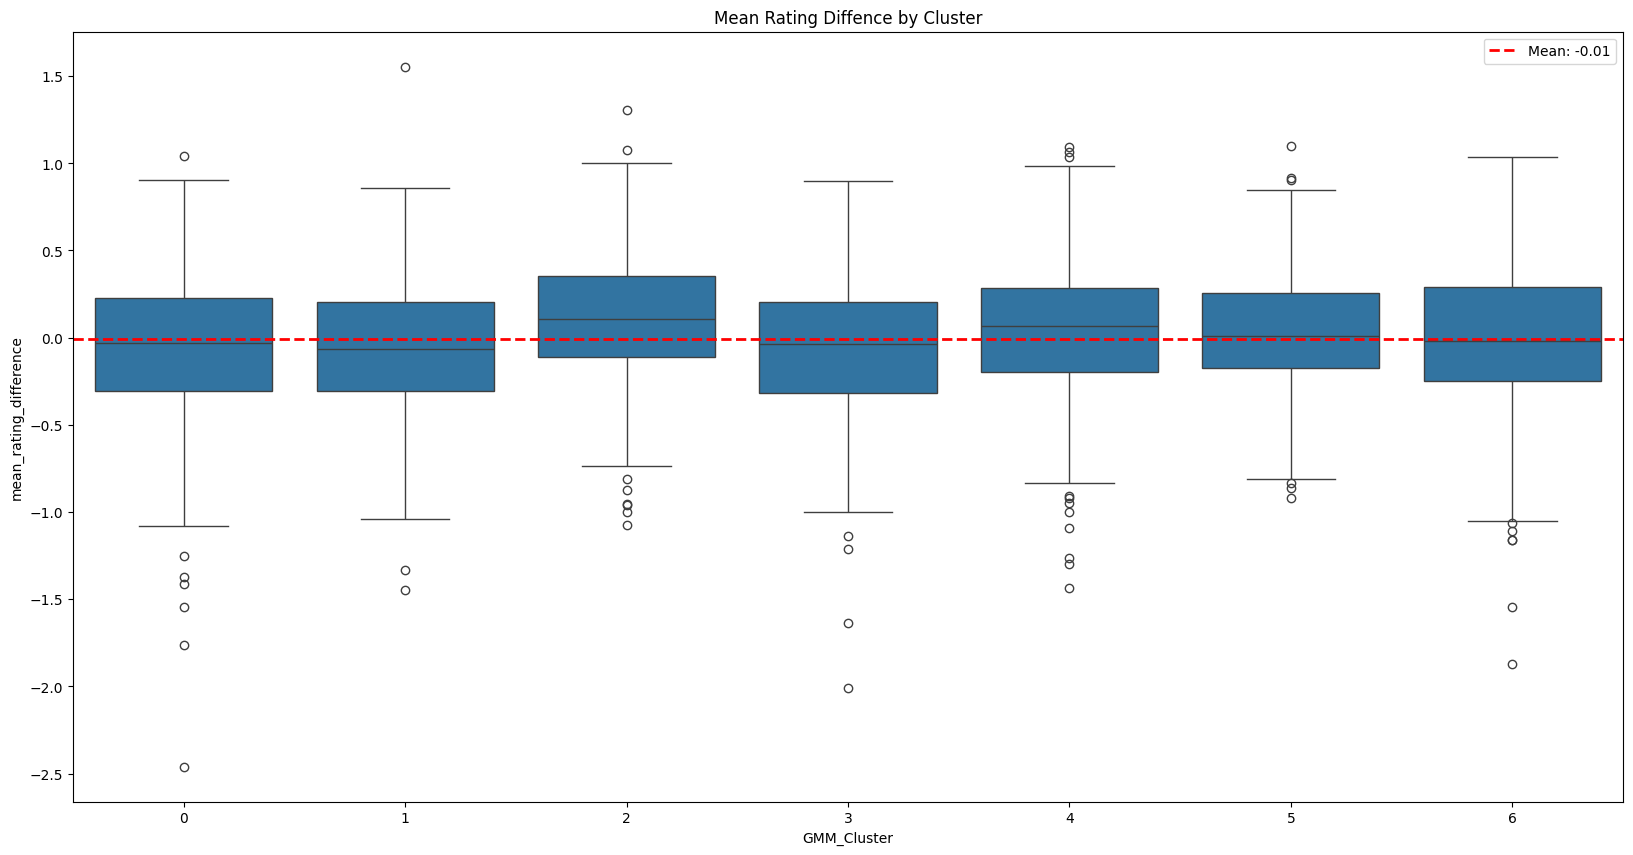

In [32]:
overall_mean_difference = df_mean['mean_rating_difference'].mean()
plt.figure(figsize=(20, 10))
sns.boxplot(x='GMM_Cluster', y='mean_rating_difference', data=df_mean)
plt.axhline(y=overall_mean_difference, color='red', linestyle='--', linewidth=2, label=f'Mean: {overall_mean_difference:.2f}')
plt.title('Mean Rating Diffence by Cluster')
plt.legend()
plt.show()

- ## Comparing Preference between Recent Movies & Old Movies by cluster

In [33]:
year_df = merged_df.copy()
year_df['year'] = year_df['title'].str.extract(r'\((\d{4})\)')
year_df = year_df[['userid','rating','avgRating','GMM_Cluster','year']]
year_df = year_df.dropna() # Drop 930 nan values
year_df.loc[:,'year'] = year_df.loc[:,'year'].astype(int)

year_df.head()

,userid,rating,avgRating,GMM_Cluster,year
0,0,5.0,3.89146,6,1995
1,0,4.0,3.15655,6,2002
2,0,3.0,3.58985,6,2000
3,0,4.0,2.98246,6,2002
4,0,3.5,3.56958,6,2012


In [35]:
year_df['rating_diff'] = year_df['rating'] - year_df['avgRating']
user_avg_diff = year_df.groupby('userid')['rating_diff'].mean().reset_index()
user_avg_diff.columns = ['userid', 'user_avg_diff']
year_df = year_df.merge(user_avg_diff, on='userid', how='left')

def year_rating_diff_correlation(group):
    return stats.pearsonr(group['year'], group['user_avg_diff'])[0]

cluster_correlations = year_df.groupby('GMM_Cluster').apply(year_rating_diff_correlation)

current_year = year_df['year'].max()
year_threshold = current_year - 10  # Consider movies from last 10 years as recent

def cluster_preference(group):
    recent = group[group['year'] > year_threshold]['user_avg_diff'].mean()
    older = group[group['year'] <= year_threshold]['user_avg_diff'].mean()
    return pd.Series({'recent_preference': recent, 'older_preference': older})

cluster_preferences = year_df.groupby('GMM_Cluster').apply(cluster_preference)

results = pd.concat([cluster_correlations, cluster_preferences], axis=1)
results.columns = ['year_rating_correlation', 'recent_preference', 'older_preference']
results['prefers_recent'] = results['recent_preference'] > results['older_preference']

print("Cluster preferences analysis:")
results


C:\Users\jwlee\AppData\Local\Temp\ipykernel_728\4165390418.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cluster_correlations = year_df.groupby('GMM_Cluster').apply(year_rating_diff_correlation)


Cluster preferences analysis:


C:\Users\jwlee\AppData\Local\Temp\ipykernel_728\4165390418.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cluster_preferences = year_df.groupby('GMM_Cluster').apply(cluster_preference)


,year_rating_correlation,recent_preference,older_preference,prefers_recent
GMM_Cluster,,,,
0,-0.021109,-0.218303,-0.202213,False
1,0.007037,-0.159464,-0.169067,True
2,-0.069638,-0.136639,-0.087560,False
3,0.033150,-0.082085,-0.102635,True
4,0.012093,-0.000609,-0.037820,True
5,0.047739,-0.081665,-0.105010,True
6,-0.003448,-0.081889,-0.091229,True


In [36]:
# Average rating difference by year and cluster
year_cluster_avg = year_df.groupby(['year', 'GMM_Cluster'])['user_avg_diff'].mean().unstack()

# Statistical test for difference in preferences
for cluster in year_df['GMM_Cluster'].unique():
    cluster_data = year_df[year_df['GMM_Cluster'] == cluster]
    recent = cluster_data[cluster_data['year'] > year_threshold]['user_avg_diff']
    older = cluster_data[cluster_data['year'] <= year_threshold]['user_avg_diff']
    t_stat, p_val = stats.ttest_ind(recent, older)
    print(f"\nCluster {cluster}:")
    print(f"T-statistic: {t_stat:.4f}, p-value: {p_val:.4f}")
    if p_val < 0.05:
        print("Significant difference in preferences for recent vs older movies.")
    else:
        print("No significant difference in preferences for recent vs older movies.")



Cluster 6:
T-statistic: 3.2305, p-value: 0.0012
Significant difference in preferences for recent vs older movies.

Cluster 4:
T-statistic: 15.2082, p-value: 0.0000
Significant difference in preferences for recent vs older movies.

Cluster 3:
T-statistic: 10.1252, p-value: 0.0000
Significant difference in preferences for recent vs older movies.

Cluster 0:
T-statistic: -6.0440, p-value: 0.0000
Significant difference in preferences for recent vs older movies.

Cluster 1:
T-statistic: 4.1356, p-value: 0.0000
Significant difference in preferences for recent vs older movies.

Cluster 5:
T-statistic: 11.9089, p-value: 0.0000
Significant difference in preferences for recent vs older movies.

Cluster 2:
T-statistic: -26.0282, p-value: 0.0000
Significant difference in preferences for recent vs older movies.


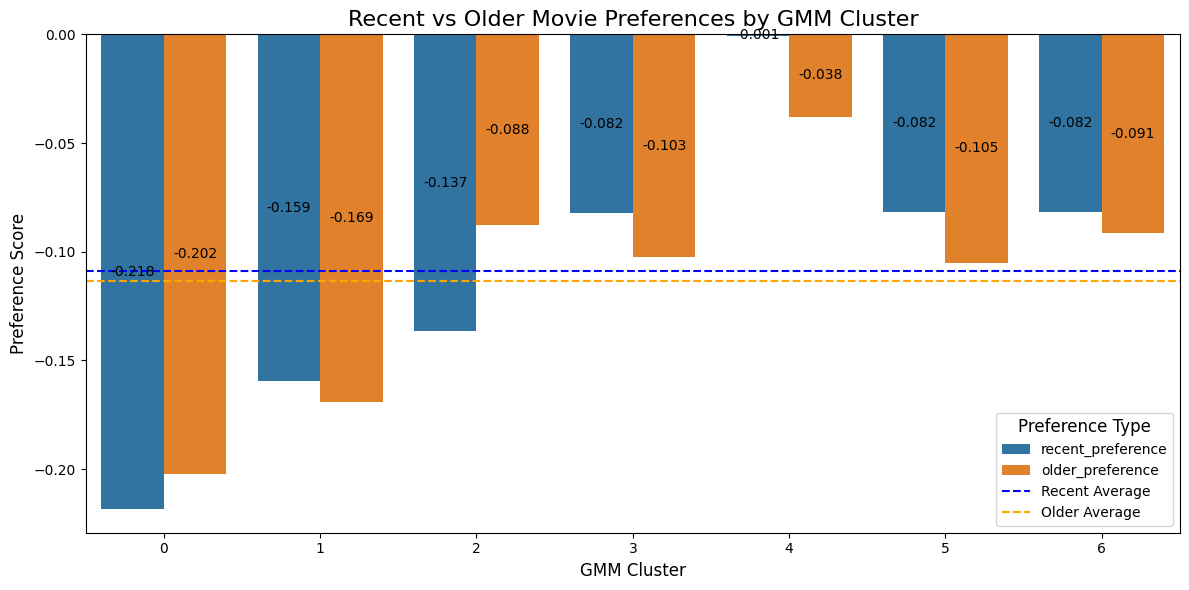

In [37]:
plot_data = results.reset_index().melt(id_vars=['GMM_Cluster'], 
                                       value_vars=['recent_preference', 'older_preference'],
                                       var_name='Preference Type', 
                                       value_name='Preference Score')

plt.figure(figsize=(12, 6))
sns.barplot(x='GMM_Cluster', y='Preference Score', hue='Preference Type', data=plot_data)
plt.title('Recent vs Older Movie Preferences by GMM Cluster', fontsize=16)
plt.xlabel('GMM Cluster', fontsize=12)
plt.ylabel('Preference Score', fontsize=12)
plt.legend(title='Preference Type', title_fontsize='12', fontsize='10')

for i in plt.gca().containers:
    plt.gca().bar_label(i, fmt='%.3f', label_type='center')

recent_avg = results['recent_preference'].mean()
older_avg = results['older_preference'].mean()

plt.axhline(y=recent_avg, color='blue', linestyle='--', label='Recent Average')
plt.axhline(y=older_avg, color='orange', linestyle='--', label='Older Average')
plt.legend(title='Preference Type', title_fontsize='12', fontsize='10', loc='lower right')
plt.tight_layout()
plt.show()